In [2]:
from main import get_stock_data, add_fin_ratios_and_commodities
import matplotlib.pyplot as plt
import numpy as np
data = get_stock_data('CS.PA', lookback = '5y')
data = add_fin_ratios_and_commodities(data)
data = data.backfill()
data.tail()

/Users/louisdelacour/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Open,High,Low,Close,Volume,Returns,Log Returns,Gold Close,WTI Oil Close,5Y TY ^FVX,CAC 40,CAC Returns
date,,,,,,,,,,,,
2022-12-01,27.160000,27.504999,26.785,27.375000,4310581,0.013138,0.013053,1801.099976,81.220001,3.680,6753.970215,0.002288
2022-12-02,27.139999,27.389999,27.045,27.389999,3661736,0.000548,0.000548,1795.900024,79.980003,3.666,6742.250000,-0.001735
2022-12-05,27.305000,27.475000,27.230,27.309999,2991466,-0.002921,-0.002925,1767.400024,76.930000,3.793,6696.959961,-0.006717
2022-12-06,27.379999,27.600000,27.320,27.459999,3898999,0.005492,0.005477,1769.300049,74.250000,3.733,6687.790039,-0.001369
2022-12-07,27.445000,27.555000,27.375,27.485001,412675,0.000910,0.000910,1785.400024,73.790001,NaN,6692.359863,0.000683


In [3]:
# Install libraries
!pip install yfinance prophet
# Get time series data
import yfinance as yf
# Prophet model for time series forecast
from prophet import Prophet
# Data processing
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [4]:
# Data start date
start_date = '2020-01-02'
# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01' 
# Date for splitting training and testing dataset
train_end_date = '2021-12-15'

In [5]:
data.drop('High', inplace=True, axis=1)
data.drop('Low', inplace=True, axis=1)
data.drop('Close', inplace=True, axis=1)
data.drop('Volume', inplace=True, axis=1)
data.drop('Returns', inplace=True, axis=1)
data.drop('Log Returns', inplace=True, axis=1)
data.drop('Gold Close', inplace=True, axis=1)
data.drop('WTI Oil Close', inplace=True, axis=1)
data.drop('5Y TY ^FVX', inplace=True, axis=1)
data.drop('CAC Returns', inplace=True, axis=1)


In [6]:
data = data.reset_index()
data.columns = ['ds', 'y', 'CAC 40']

In [7]:
data.tail()

,ds,y,CAC 40
1277,2022-12-01,27.160000,6753.970215
1278,2022-12-02,27.139999,6742.250000
1279,2022-12-05,27.305000,6696.959961
1280,2022-12-06,27.379999,6687.790039
1281,2022-12-07,27.445000,6692.359863


In [8]:
# Train test split
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]
# Check the shape of the dataset
print(train.shape)
print(test.shape)

(1029, 3)
(253, 3)


In [9]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()
# Fit the model on the training dataset
model_baseline.fit(train)

10:29:59 - cmdstanpy - INFO - Chain [1] start processing
10:29:59 - cmdstanpy - INFO - Chain [1] done processing


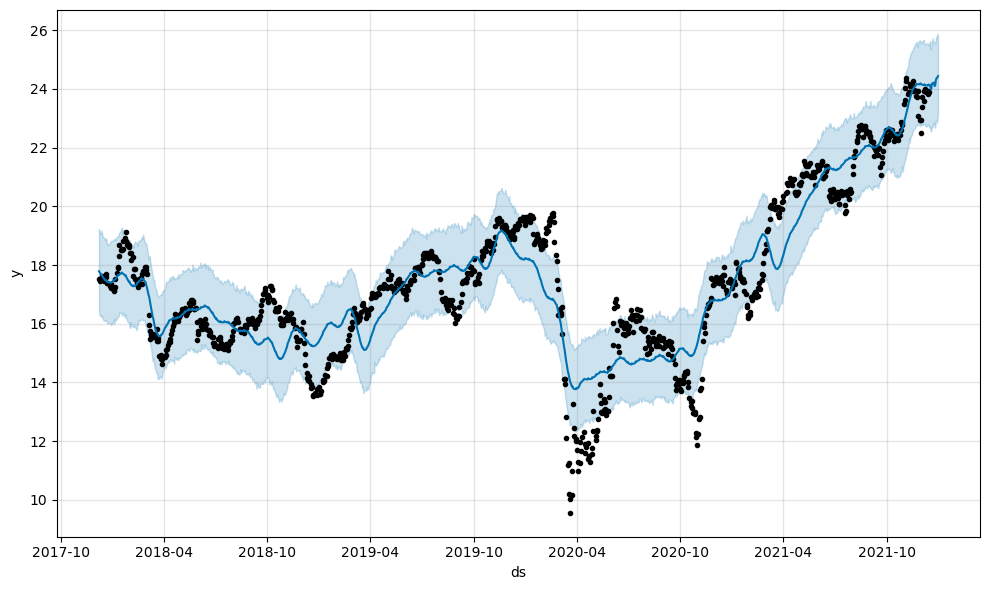

In [10]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=16)
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

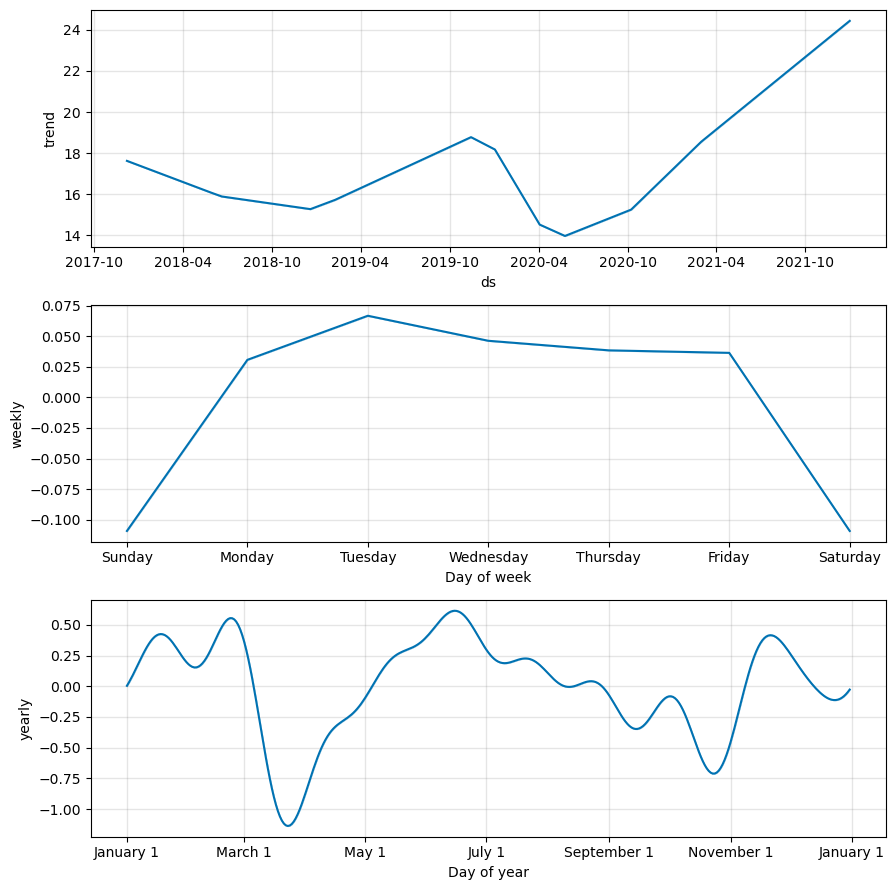

In [11]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [12]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 0.2562846276085938
The MAPE for the baseline model is 0.010758090177941134


In [13]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
# Fit the model on the training dataset
model_season.fit(train)

10:30:00 - cmdstanpy - INFO - Chain [1] start processing
10:30:01 - cmdstanpy - INFO - Chain [1] done processing


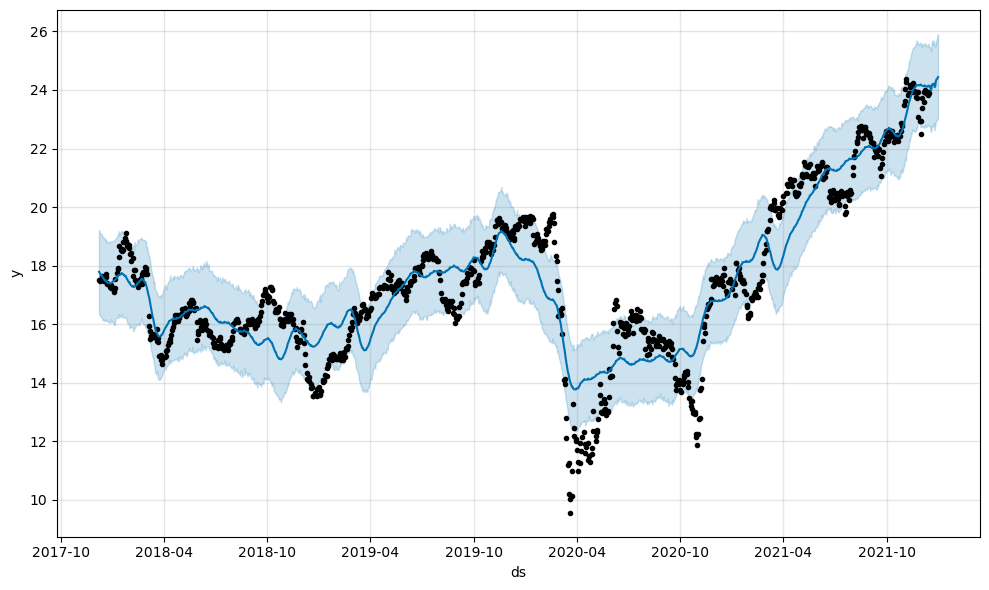

In [14]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=16)
# Make prediction
forecast_season = model_season.predict(future_season)
# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

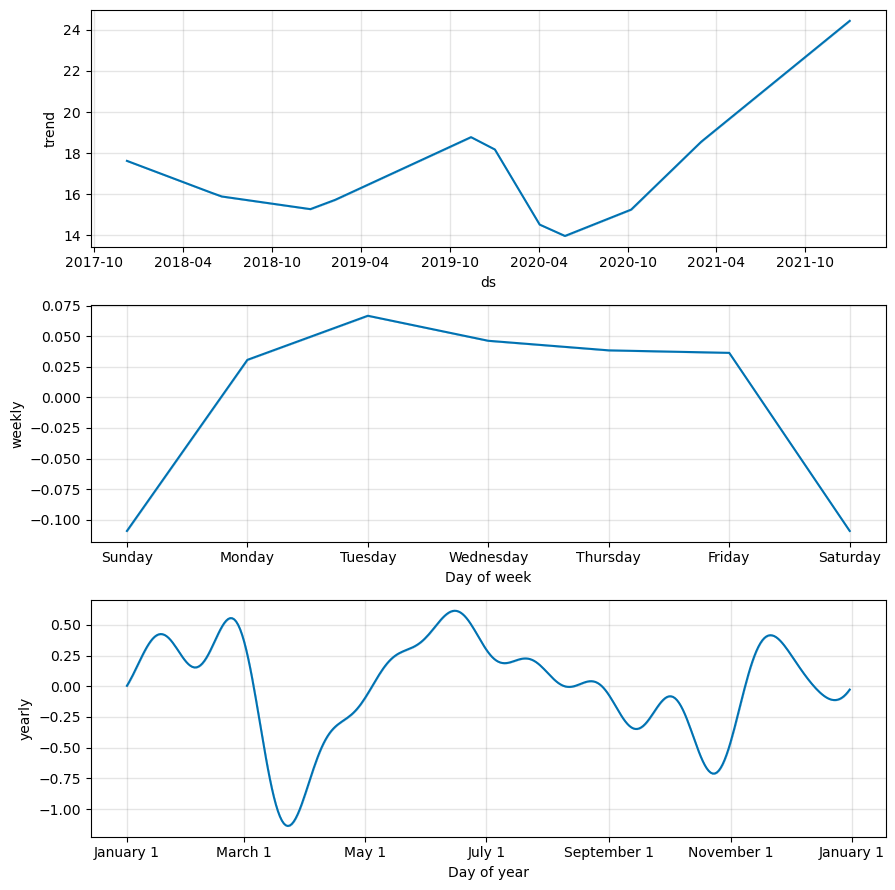

In [15]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [16]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')
# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 0.2562846276085938
The MAPE for the seasonality model is 0.010758090177941134


In [17]:
# Add seasonality 
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
# Add regressor
model_multivariate.add_regressor('CAC 40', standardize=False)
# Fit the model on the training dataset
model_multivariate.fit(train)

10:30:01 - cmdstanpy - INFO - Chain [1] start processing
10:30:01 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)
# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'CAC 40']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
# Check the data
future_multivariate.tail(10)

,ds,CAC 40
1031,2021-12-20,6870.100098
1032,2021-12-21,6964.990234
1033,2021-12-22,7051.669922
1034,2021-12-23,7106.149902
1035,2021-12-24,7086.580078
1036,2021-12-27,7140.390137
1037,2021-12-28,7181.109863
1038,2021-12-29,7161.520020
1039,2021-12-30,7173.229980
1040,2021-12-31,7153.029785


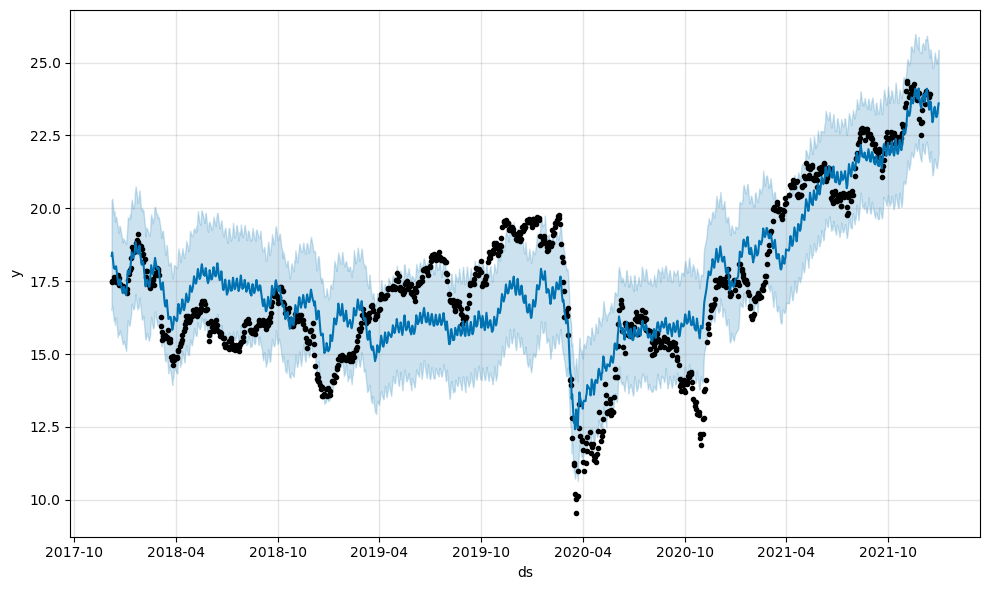

In [19]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

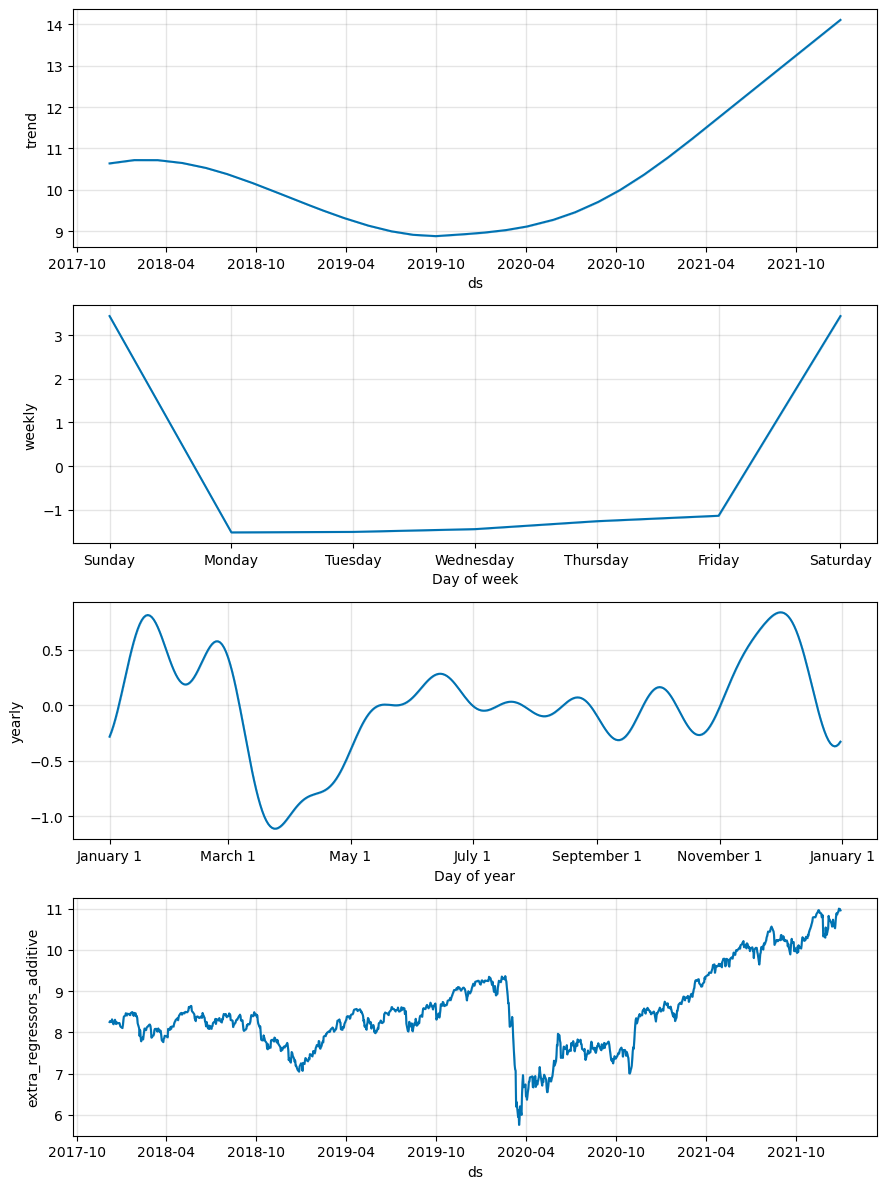

In [20]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [21]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 0.7761350566435
The MAPE for the multivariate model is 0.03200079048726369


In [22]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,    
})
# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,    
})
# Combine all events
events = pd.concat((COVID, superbowl))
# Take a look at the events data
events


,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [23]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='FR')
# Add regressor
model_holiday.add_regressor('CAC 40', standardize=False)
# Fit the model on the training dataset
model_holiday.fit(train)
# All the holidays and events
model_holiday.train_holiday_names

10:30:03 - cmdstanpy - INFO - Chain [1] start processing
10:30:03 - cmdstanpy - INFO - Chain [1] done processing


0                  COVID
1              superbowl
2           Jour de l'an
3        Fête du Travail
4         Armistice 1945
5         Fête nationale
6         Armistice 1918
7        Lundi de Pâques
8     Lundi de Pentecôte
9              Ascension
10            Assomption
11             Toussaint
12                  Noël
dtype: object

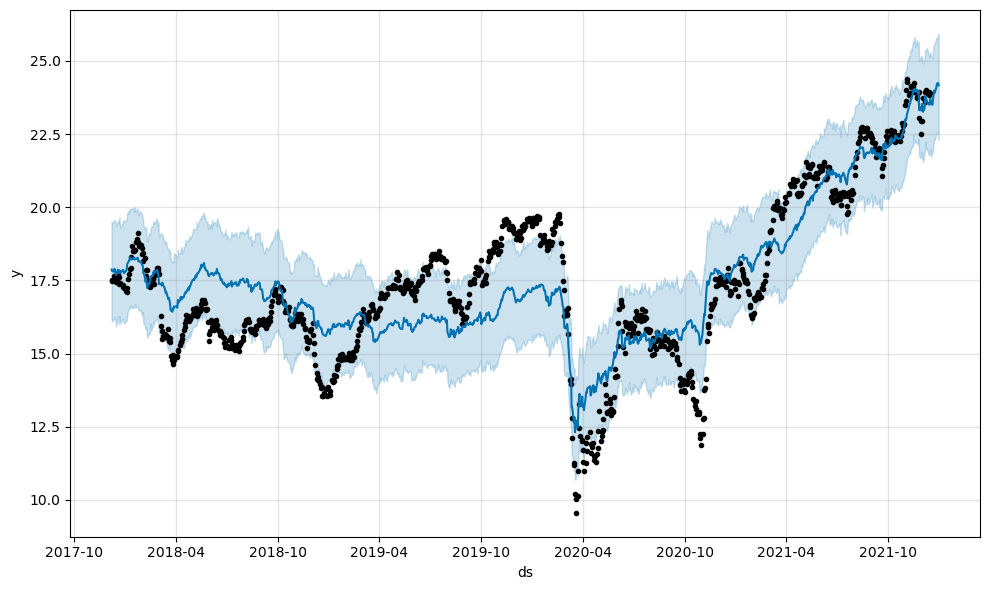

In [24]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)
# Append the regressor values
future_holiday = pd.merge(future_holiday, data[['ds', 'CAC 40']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [25]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')
# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 0.25485086014350483
The MAPE for the holiday/event model is 0.010519500727842683


In [26]:
# Check correlation
data.corrwith(data["y"])

y         1.000000
CAC 40    0.927506
dtype: float64

In [29]:
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
1038,2021-12-29,24.178302,22.514225,25.786769
1039,2021-12-30,24.248084,22.573966,25.882765
1040,2021-12-31,24.166966,22.310172,25.924236


In [30]:
getNbOfDay = 3
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(getNbOfDay)

,ds,yhat,yhat_lower,yhat_upper
1038,2021-12-29,24.178302,22.514225,25.786769
1039,2021-12-30,24.248084,22.573966,25.882765
1040,2021-12-31,24.166966,22.310172,25.924236
